In [1]:
%matplotlib inline

import numpy as np
import copy
import matplotlib.pyplot as plt
import pickle
import random
import torch
from utils import torch_from_numpy
import datetime

from config import cfg_seed, cfg_env, cfg_z_dim, cfg_default_lr, cfg_default_early
seed = cfg_seed
env_str=cfg_env
default_lr=cfg_default_lr
default_early=cfg_default_early

from config import cfg_alpha
alpha=cfg_alpha

num_iter_max=200000
env_name = 'CustomCartPole-v0'
env_str=cfg_env
figfilenamehead = "fig_policy_optimization_"+env_str+"_iter1_"

loss_list = []
normalized_loss_list = []

print("alpha",alpha)
print(datetime.datetime.now())

alpha 0.2
2023-06-08 14:13:44.425366


In [2]:
import gym
import custom_gym
env = gym.make(env_name)

np.random.seed(seed)
random.seed(seed)
env.seed(seed)
env.action_space.seed(seed)
torch.manual_seed(seed)

s_dim = env.reset().flatten().shape[0]
a_dim = env.action_space.sample().flatten().shape[0]
z_dim = cfg_z_dim
print(s_dim, a_dim, z_dim)



4 1 2


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/core.py:268: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [3]:


from sac import SAC
# agent = SAC(env.observation_space.shape[0], env.action_space)
agent = SAC(env.observation_space.shape[0]+z_dim*2, env.action_space)
agent.load_checkpoint(ckpt_path="checkpoints/sac_checkpoint_custom_"+env_str+"_bamdp_standardvae_")


offline_data = pickle.load(open("offline_data_"+env_str+".pkl","rb"))
debug_info = pickle.load(open("offline_data_debug_info_"+env_str+".pkl","rb"))
debug_info = np.array(debug_info)

Loading models from checkpoints/sac_checkpoint_custom_cartpole_bamdp_standardvae_


In [4]:
args_init_dict = {
    "offline_data": offline_data,
    "s_dim": s_dim,
    "a_dim": a_dim,
    "z_dim": z_dim,
    #              "policy":agent.select_action,
    "mdp_policy":None,
    "bamdp_policy":agent.policy.my_np_select_action,
    "debug_info":debug_info,
    "env" : env,
    "ckpt_suffix" : env_str,
}
# import vi_base
# vi = vi_base.baseVI(args_init_dict)
import vi_iw
iwvi = vi_iw.iwVI(args_init_dict)

iwvi.load_base(ckpt_key="unweighted")
# iwvi.update_mulogvar_offlinedata()

dec: h_dim 64
base load ckpt ckpt_basevi_cartpole_unweighted
base load self.initial_belief.data.sum() tensor(-3.0514)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(-3.4609)
penalty_target_min tensor(-11.9806) penalty_target_max tensor(3.1330)
train_loss:  -9.819340663146972
valid_loss:  -9.20669306640625
h_min_tilde -11.980572 ell_tilde -9.69681114379883 kappa_tilde 0.0006617206865259105


In [5]:
iwvi.get_real_rollout_bamdppolicy_data()


 0 7.152557373046875e-07


/home/proxima-hishinuma/anaconda3/envs/iwvi/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):



 1 4.033634185791016

 2 3.1282896995544434

 3 3.1528356075286865

 4 3.1178691387176514

 5 3.1814165115356445

 6 3.1082701683044434

 7 3.0824878215789795

 8 3.348677635192871

 9 939.9375412464142

 10 5.512700319290161

 11 4.559296607971191

 12 3.2304468154907227

 13 3.2675085067749023

 14 3.1667916774749756

 15 3.099997043609619

 16 3.1238467693328857

 17 3.39725923538208

 18 3.248924732208252

 19 3.162447690963745

 20 3.154778242111206

 21 3.136833906173706

 22 3.0636162757873535

 23 3.1527271270751953

 24 3.091902017593384

 25 3.2141830921173096

 26 3.2276453971862793

 27 3.212831497192383

 28 3.1371123790740967

 29 3.0882630348205566

 30 3.1391849517822266

 31 3.1640031337738037

 32 3.156498908996582

 33 3.1273744106292725

 34 3.1142523288726807

 35 3.06404185295105

 36 3.1867268085479736

 37 3.2762091159820557

 38 3.120413064956665

 39 3.12387752532959

 40 3.1411848068237305

 41 3.1204423904418945

 42 3.126102924346924

 43 3.097480535507202

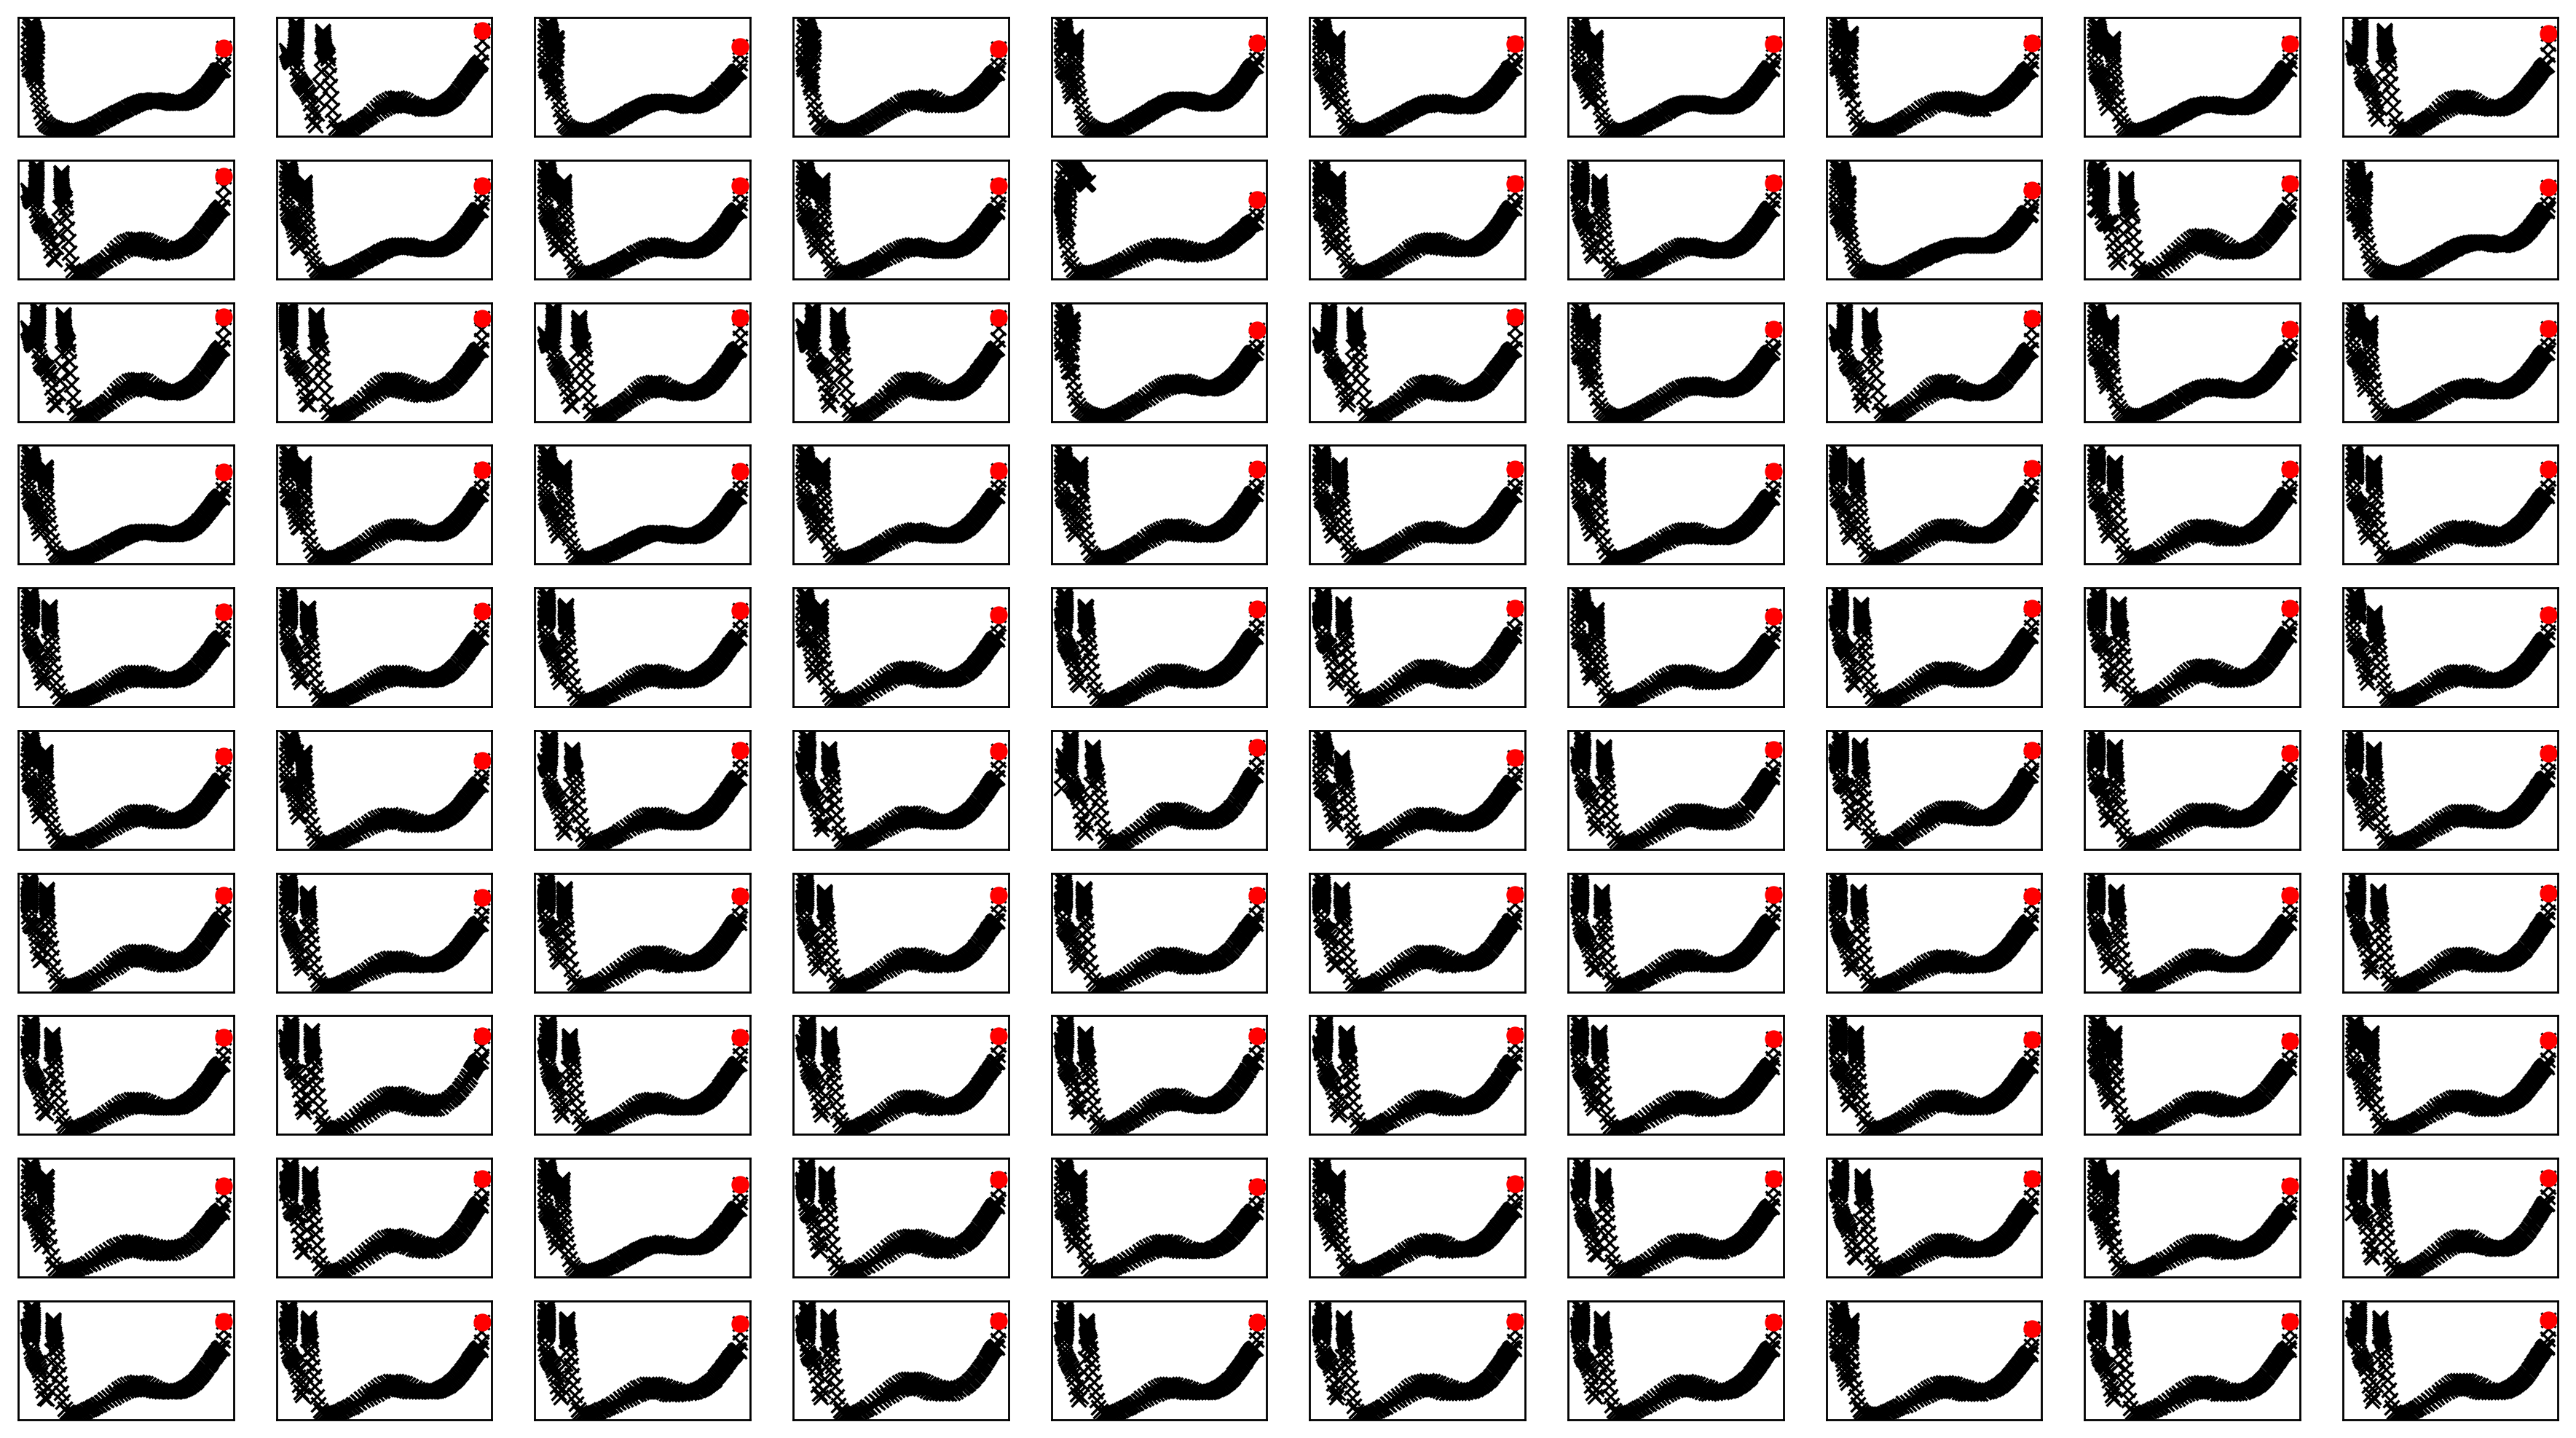

In [6]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,0], iwvi.debug_realenv_rolloutdata[i][:,1],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

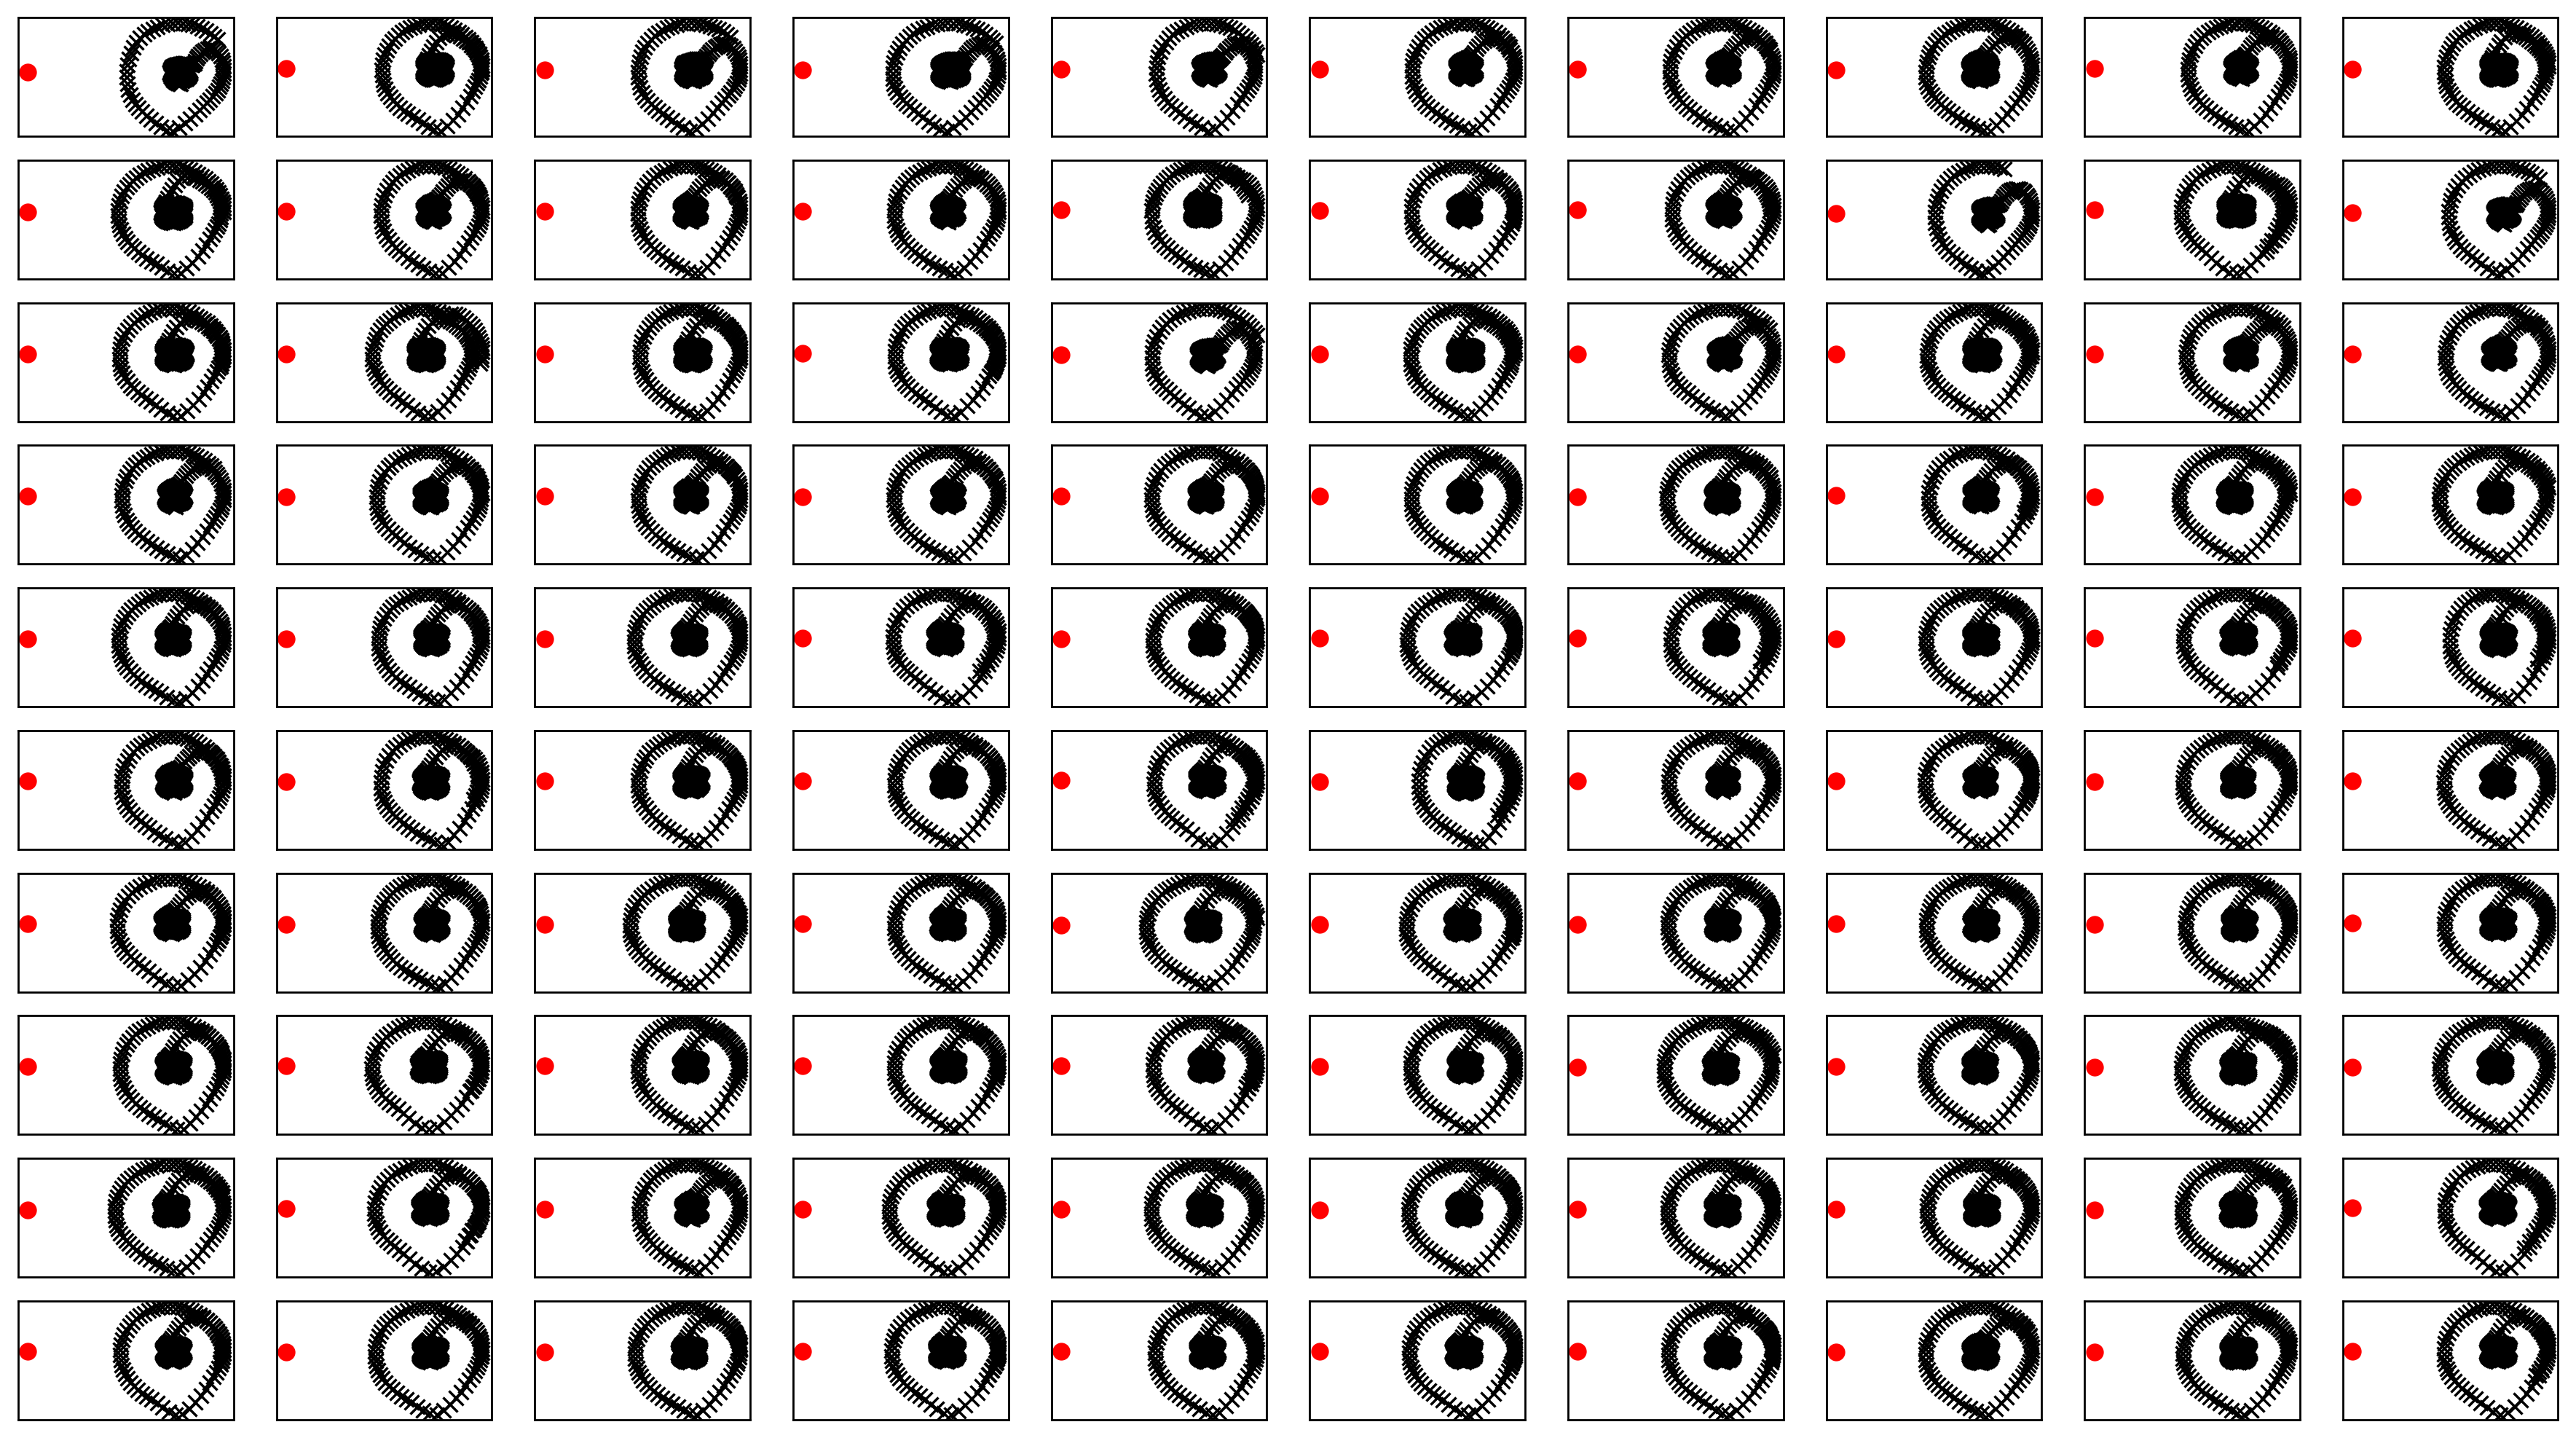

In [7]:
fig = plt.figure(figsize=(18,10), dpi=250)
fig.patch.set_facecolor('white')
ax_list = []
for i in range(len(offline_data)):
    ax_list.append(fig.add_subplot(len(offline_data)//10, 10, i+1))
    ax_list[-1].set_xticks([])
    ax_list[-1].set_yticks([])
    ax_list[-1].plot(iwvi.debug_realenv_rolloutdata[i][:,2], iwvi.debug_realenv_rolloutdata[i][:,3],"kx")
    ax_list[-1].plot(0, 0,"ro") 
plt.show()

In [8]:
print(datetime.datetime.now())

2023-06-08 14:34:42.202183


# Iter 1

In [9]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11
predict diverge [  9.09013188   9.37074322 -16.87887208 -23.18150658] [ 0.20902756  0.28031886 -0.43088798 -1.57958037] [32.84908  10.318261 49.842476 22.503405] [16.42454    5.1591306 24.921238  11.251702 ] sim_timestep 123

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40
predict diverge [  5.32111918  10.35009014 -12.14969325 -17.9309605 ] [ 0.12131892  0.28307279 -0.23258193  0.23176185] [32.84908  10.318261 49.842476 22.503405] [16.42454    5.1591306 24.921238  11.251702 ] sim_timestep 98

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65
predict diverge [  6.94020973   7.82483142 -19.80387589 -22.69395788] [ 0.16253905 -0.94273285 -0.46885547 -1.73467924] [32.84908  10.318261 49.842476 22.503405] [16.42454    5.1591306 24.921238  11.251702 ] sim_timestep 126

 66



In [10]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 1.36901  validloss 1.40777±0.00000  bestvalidloss 1.40777  last_update 0
train: iter 1  trainloss 1.33681  validloss 1.33716±0.00000  bestvalidloss 1.33716  last_update 0
train: iter 2  trainloss 1.30962  validloss 1.29578±0.00000  bestvalidloss 1.29578  last_update 0
train: iter 3  trainloss 1.29069  validloss 1.26800±0.00000  bestvalidloss 1.26800  last_update 0
train: iter 4  trainloss 1.27217  validloss 1.24532±0.00000  bestvalidloss 1.24532  last_update 0
train: iter 5  trainloss 1.24821  validloss 1.21993±0.00000  bestvalidloss 1.21993  last_update 0
train: iter 6  trainloss 1.22501  validloss 1.19621±0.00000  bestvalidloss 1.19621  last_update 0
train: iter 7  trainloss 1.19580  validloss 1.16653±0.00000  bestvalidloss 1.16653  last_update 0
train: iter 8  trainloss 1.17116  validloss 1.13965±0.00000  bestvalidloss 1.13965  last_update 0
train: iter 9  trainloss 1.14871  validloss 1.11773±0.00000  bestvalidloss 1.11773  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.84939  validloss 0.87451±0.00000  bestvalidloss 0.85965  last_update 1
train: iter 84  trainloss 0.85349  validloss 0.86106±0.00000  bestvalidloss 0.85965  last_update 2
train: iter 85  trainloss 0.84516  validloss 0.86273±0.00000  bestvalidloss 0.85965  last_update 3
train: iter 86  trainloss 0.84973  validloss 0.86103±0.00000  bestvalidloss 0.85965  last_update 4
train: iter 87  trainloss 0.84693  validloss 0.86357±0.00000  bestvalidloss 0.85965  last_update 5
train: iter 88  trainloss 0.84044  validloss 0.85564±0.00000  bestvalidloss 0.85564  last_update 0
train: iter 89  trainloss 0.83534  validloss 0.87916±0.00000  bestvalidloss 0.85564  last_update 1
train: iter 90  trainloss 0.83029  validloss 0.86008±0.00000  bestvalidloss 0.85564  last_update 2
train: iter 91  trainloss 0.83624  validloss 0.87931±0.00000  bestvalidloss 0.85564  last_update 3
train: iter 92  trainloss 0.82564  validloss 0.86291±0.00000  bestvalidloss 0.85564  last_update 4
train: ite

train: iter 166  trainloss 0.72933  validloss 0.79225±0.00000  bestvalidloss 0.79225  last_update 0
train: iter 167  trainloss 0.72360  validloss 0.79841±0.00000  bestvalidloss 0.79225  last_update 1
train: iter 168  trainloss 0.72098  validloss 0.84913±0.00000  bestvalidloss 0.79225  last_update 2
train: iter 169  trainloss 0.72019  validloss 0.80848±0.00000  bestvalidloss 0.79225  last_update 3
train: iter 170  trainloss 0.70557  validloss 0.79775±0.00000  bestvalidloss 0.79225  last_update 4
train: iter 171  trainloss 0.73426  validloss 0.80975±0.00000  bestvalidloss 0.79225  last_update 5
train: iter 172  trainloss 0.71055  validloss 0.82277±0.00000  bestvalidloss 0.79225  last_update 6
train: iter 173  trainloss 0.70812  validloss 0.80031±0.00000  bestvalidloss 0.79225  last_update 7
train: iter 174  trainloss 0.71658  validloss 0.80728±0.00000  bestvalidloss 0.79225  last_update 8
train: iter 175  trainloss 0.70826  validloss 0.85456±0.00000  bestvalidloss 0.79225  last_update 9


train: iter 248  trainloss 0.62903  validloss 0.75447±0.00000  bestvalidloss 0.72706  last_update 2
train: iter 249  trainloss 0.63968  validloss 0.73173±0.00000  bestvalidloss 0.72706  last_update 3
train: iter 250  trainloss 0.64196  validloss 0.75674±0.00000  bestvalidloss 0.72706  last_update 4
train: iter 251  trainloss 0.64548  validloss 0.73711±0.00000  bestvalidloss 0.72706  last_update 5
train: iter 252  trainloss 0.64355  validloss 0.73818±0.00000  bestvalidloss 0.72706  last_update 6
train: iter 253  trainloss 0.64589  validloss 0.74121±0.00000  bestvalidloss 0.72706  last_update 7
train: iter 254  trainloss 0.63332  validloss 0.75173±0.00000  bestvalidloss 0.72706  last_update 8
train: iter 255  trainloss 0.63046  validloss 0.73330±0.00000  bestvalidloss 0.72706  last_update 9
train: iter 256  trainloss 0.63343  validloss 0.73342±0.00000  bestvalidloss 0.72706  last_update 10
train: iter 257  trainloss 0.63674  validloss 0.72174±0.00000  bestvalidloss 0.72174  last_update 0

train: iter 331  trainloss 0.58183  validloss 0.72775±0.00000  bestvalidloss 0.69382  last_update 2
train: iter 332  trainloss 0.58680  validloss 0.70724±0.00000  bestvalidloss 0.69382  last_update 3
train: iter 333  trainloss 0.57187  validloss 0.69166±0.00000  bestvalidloss 0.69166  last_update 0
train: iter 334  trainloss 0.58758  validloss 0.71377±0.00000  bestvalidloss 0.69166  last_update 1
train: iter 335  trainloss 0.59247  validloss 0.72511±0.00000  bestvalidloss 0.69166  last_update 2
train: iter 336  trainloss 0.58137  validloss 0.69403±0.00000  bestvalidloss 0.69166  last_update 3
train: iter 337  trainloss 0.57819  validloss 0.71282±0.00000  bestvalidloss 0.69166  last_update 4
train: iter 338  trainloss 0.57690  validloss 0.69998±0.00000  bestvalidloss 0.69166  last_update 5
train: iter 339  trainloss 0.57783  validloss 0.73847±0.00000  bestvalidloss 0.69166  last_update 6
train: iter 340  trainloss 0.57003  validloss 0.71428±0.00000  bestvalidloss 0.69166  last_update 7


train: iter 413  trainloss 0.55150  validloss 0.67956±0.00000  bestvalidloss 0.67285  last_update 6
train: iter 414  trainloss 0.55717  validloss 0.68148±0.00000  bestvalidloss 0.67285  last_update 7
train: iter 415  trainloss 0.54298  validloss 0.69826±0.00000  bestvalidloss 0.67285  last_update 8
train: iter 416  trainloss 0.55181  validloss 0.68377±0.00000  bestvalidloss 0.67285  last_update 9
train: iter 417  trainloss 0.55181  validloss 0.69548±0.00000  bestvalidloss 0.67285  last_update 10
train: iter 418  trainloss 0.55483  validloss 0.69597±0.00000  bestvalidloss 0.67285  last_update 11
train: iter 419  trainloss 0.53662  validloss 0.67498±0.00000  bestvalidloss 0.67285  last_update 12
train: iter 420  trainloss 0.54629  validloss 0.68007±0.00000  bestvalidloss 0.67285  last_update 13
train: iter 421  trainloss 0.54872  validloss 0.74006±0.00000  bestvalidloss 0.67285  last_update 14
train: iter 422  trainloss 0.53814  validloss 0.68513±0.00000  bestvalidloss 0.67285  last_upda

train: iter 495  trainloss 0.52689  validloss 0.67453±0.00000  bestvalidloss 0.65001  last_update 17
train: iter 496  trainloss 0.52371  validloss 0.66914±0.00000  bestvalidloss 0.65001  last_update 18
train: iter 497  trainloss 0.52251  validloss 0.68121±0.00000  bestvalidloss 0.65001  last_update 19
train: iter 498  trainloss 0.53147  validloss 0.69457±0.00000  bestvalidloss 0.65001  last_update 20
train: iter 499  trainloss 0.51452  validloss 0.67353±0.00000  bestvalidloss 0.65001  last_update 21
train: iter 500  trainloss 0.51532  validloss 0.68476±0.00000  bestvalidloss 0.65001  last_update 22
train: iter 501  trainloss 0.52089  validloss 0.67456±0.00000  bestvalidloss 0.65001  last_update 23
train: iter 502  trainloss 0.52604  validloss 0.65164±0.00000  bestvalidloss 0.65001  last_update 24
train: iter 503  trainloss 0.52434  validloss 0.67291±0.00000  bestvalidloss 0.65001  last_update 25
train: iter 504  trainloss 0.51619  validloss 0.67606±0.00000  bestvalidloss 0.65001  last_

train: iter 577  trainloss 0.51640  validloss 0.67544±0.00000  bestvalidloss 0.63887  last_update 32
train: iter 578  trainloss 0.50087  validloss 0.67246±0.00000  bestvalidloss 0.63887  last_update 33
train: iter 579  trainloss 0.49943  validloss 0.66583±0.00000  bestvalidloss 0.63887  last_update 34
train: iter 580  trainloss 0.49434  validloss 0.69869±0.00000  bestvalidloss 0.63887  last_update 35
train: iter 581  trainloss 0.49466  validloss 0.69748±0.00000  bestvalidloss 0.63887  last_update 36
train: iter 582  trainloss 0.50394  validloss 0.64959±0.00000  bestvalidloss 0.63887  last_update 37
train: iter 583  trainloss 0.50192  validloss 0.65495±0.00000  bestvalidloss 0.63887  last_update 38
train: iter 584  trainloss 0.50707  validloss 0.67586±0.00000  bestvalidloss 0.63887  last_update 39
train: iter 585  trainloss 0.50649  validloss 0.63583±0.00000  bestvalidloss 0.63583  last_update 0
train: iter 586  trainloss 0.50065  validloss 0.72073±0.00000  bestvalidloss 0.63583  last_u

train: iter 660  trainloss 0.48546  validloss 0.67098±0.00000  bestvalidloss 0.62685  last_update 1
train: iter 661  trainloss 0.47310  validloss 0.64559±0.00000  bestvalidloss 0.62685  last_update 2
train: iter 662  trainloss 0.47502  validloss 0.64945±0.00000  bestvalidloss 0.62685  last_update 3
train: iter 663  trainloss 0.47973  validloss 0.64113±0.00000  bestvalidloss 0.62685  last_update 4
train: iter 664  trainloss 0.48159  validloss 0.67156±0.00000  bestvalidloss 0.62685  last_update 5
train: iter 665  trainloss 0.48145  validloss 0.63605±0.00000  bestvalidloss 0.62685  last_update 6
train: iter 666  trainloss 0.47082  validloss 0.63168±0.00000  bestvalidloss 0.62685  last_update 7
train: iter 667  trainloss 0.48535  validloss 0.68630±0.00000  bestvalidloss 0.62685  last_update 8
train: iter 668  trainloss 0.48494  validloss 0.67667±0.00000  bestvalidloss 0.62685  last_update 9
train: iter 669  trainloss 0.47353  validloss 0.67382±0.00000  bestvalidloss 0.62685  last_update 10

train: iter 742  trainloss 0.46099  validloss 0.64041±0.00000  bestvalidloss 0.61925  last_update 33
train: iter 743  trainloss 0.47250  validloss 0.62877±0.00000  bestvalidloss 0.61925  last_update 34
train: iter 744  trainloss 0.46641  validloss 0.63422±0.00000  bestvalidloss 0.61925  last_update 35
train: iter 745  trainloss 0.46637  validloss 0.62923±0.00000  bestvalidloss 0.61925  last_update 36
train: iter 746  trainloss 0.46299  validloss 0.62822±0.00000  bestvalidloss 0.61925  last_update 37
train: iter 747  trainloss 0.44979  validloss 0.64358±0.00000  bestvalidloss 0.61925  last_update 38
train: iter 748  trainloss 0.45702  validloss 0.64406±0.00000  bestvalidloss 0.61925  last_update 39
train: iter 749  trainloss 0.45824  validloss 0.63482±0.00000  bestvalidloss 0.61925  last_update 40
train: iter 750  trainloss 0.45946  validloss 0.62849±0.00000  bestvalidloss 0.61925  last_update 41
train: iter 751  trainloss 0.46305  validloss 0.67132±0.00000  bestvalidloss 0.61925  last_

train: iter 824  trainloss 0.44671  validloss 0.60893±0.00000  bestvalidloss 0.60784  last_update 7
train: iter 825  trainloss 0.45875  validloss 0.61105±0.00000  bestvalidloss 0.60784  last_update 8
train: iter 826  trainloss 0.44124  validloss 0.63867±0.00000  bestvalidloss 0.60784  last_update 9
train: iter 827  trainloss 0.44708  validloss 0.64009±0.00000  bestvalidloss 0.60784  last_update 10
train: iter 828  trainloss 0.44987  validloss 0.65199±0.00000  bestvalidloss 0.60784  last_update 11
train: iter 829  trainloss 0.44345  validloss 0.63321±0.00000  bestvalidloss 0.60784  last_update 12
train: iter 830  trainloss 0.44591  validloss 0.63123±0.00000  bestvalidloss 0.60784  last_update 13
train: iter 831  trainloss 0.45265  validloss 0.62785±0.00000  bestvalidloss 0.60784  last_update 14
train: iter 832  trainloss 0.44159  validloss 0.64711±0.00000  bestvalidloss 0.60784  last_update 15
train: iter 833  trainloss 0.44114  validloss 0.60573±0.00000  bestvalidloss 0.60573  last_upd

train: iter 906  trainloss 0.42560  validloss 0.63630±0.00000  bestvalidloss 0.59810  last_update 52
train: iter 907  trainloss 0.43304  validloss 0.61750±0.00000  bestvalidloss 0.59810  last_update 53
train: iter 908  trainloss 0.42519  validloss 0.63685±0.00000  bestvalidloss 0.59810  last_update 54
train: iter 909  trainloss 0.43140  validloss 0.60759±0.00000  bestvalidloss 0.59810  last_update 55
train: iter 910  trainloss 0.43242  validloss 0.62829±0.00000  bestvalidloss 0.59810  last_update 56
train: iter 911  trainloss 0.43636  validloss 0.62764±0.00000  bestvalidloss 0.59810  last_update 57
train: iter 912  trainloss 0.43391  validloss 0.59833±0.00000  bestvalidloss 0.59810  last_update 58
train: iter 913  trainloss 0.42189  validloss 0.60602±0.00000  bestvalidloss 0.59810  last_update 59
train: iter 914  trainloss 0.42706  validloss 0.61475±0.00000  bestvalidloss 0.59810  last_update 60
train: iter 915  trainloss 0.42919  validloss 0.64426±0.00000  bestvalidloss 0.59810  last_

train: iter 989  trainloss 0.41092  validloss 0.61442±0.00000  bestvalidloss 0.58511  last_update 8
train: iter 990  trainloss 0.41909  validloss 0.59680±0.00000  bestvalidloss 0.58511  last_update 9
train: iter 991  trainloss 0.40721  validloss 0.59100±0.00000  bestvalidloss 0.58511  last_update 10
train: iter 992  trainloss 0.41105  validloss 0.62692±0.00000  bestvalidloss 0.58511  last_update 11
train: iter 993  trainloss 0.41348  validloss 0.61140±0.00000  bestvalidloss 0.58511  last_update 12
train: iter 994  trainloss 0.40914  validloss 0.60204±0.00000  bestvalidloss 0.58511  last_update 13
train: iter 995  trainloss 0.40699  validloss 0.61330±0.00000  bestvalidloss 0.58511  last_update 14
train: iter 996  trainloss 0.40712  validloss 0.60760±0.00000  bestvalidloss 0.58511  last_update 15
train: iter 997  trainloss 0.42408  validloss 0.58294±0.00000  bestvalidloss 0.58294  last_update 0
train: iter 998  trainloss 0.40381  validloss 0.61504±0.00000  bestvalidloss 0.58294  last_upd

train: iter 1070  trainloss 0.39518  validloss 0.59399±0.00000  bestvalidloss 0.58294  last_update 73
train: iter 1071  trainloss 0.42860  validloss 0.67584±0.00000  bestvalidloss 0.58294  last_update 74
train: iter 1072  trainloss 0.40148  validloss 0.61250±0.00000  bestvalidloss 0.58294  last_update 75
train: iter 1073  trainloss 0.39281  validloss 0.59325±0.00000  bestvalidloss 0.58294  last_update 76
train: iter 1074  trainloss 0.39429  validloss 0.61595±0.00000  bestvalidloss 0.58294  last_update 77
train: iter 1075  trainloss 0.40018  validloss 0.59670±0.00000  bestvalidloss 0.58294  last_update 78
train: iter 1076  trainloss 0.39227  validloss 0.59834±0.00000  bestvalidloss 0.58294  last_update 79
train: iter 1077  trainloss 0.39158  validloss 0.61746±0.00000  bestvalidloss 0.58294  last_update 80
train: iter 1078  trainloss 0.39974  validloss 0.64094±0.00000  bestvalidloss 0.58294  last_update 81
train: iter 1079  trainloss 0.39337  validloss 0.61432±0.00000  bestvalidloss 0.58

([1.369009856879711,
  1.3368090689182281,
  1.309623020887375,
  1.290688904374838,
  1.272166308015585,
  1.2482084274291991,
  1.2250084288418293,
  1.1958016104996205,
  1.1711628571152688,
  1.148714542388916,
  1.1303005561232566,
  1.1171918213367462,
  1.1012545019388198,
  1.0923623599112033,
  1.0795167706906796,
  1.0707425974309444,
  1.0821359306573868,
  1.0635320529341699,
  1.0573951862752438,
  1.0498350150883198,
  1.0438715003430843,
  1.0438631422817708,
  1.035643783956766,
  1.03057244643569,
  1.0237733192741871,
  1.0232074372470379,
  1.0144910931587219,
  1.0136405684053897,
  1.0047197856009007,
  1.0004860535264015,
  1.0080543853342534,
  0.9916321188211441,
  0.9906862512230873,
  0.9951346106827259,
  0.9842361330986023,
  0.9770677454769612,
  0.9868348605930806,
  0.970767506211996,
  0.9689958602190017,
  0.966873187571764,
  0.9606934368610383,
  0.9653721004724503,
  0.9603791408240795,
  0.9544480174779892,
  0.9532117247581482,
  0.946432001888752,

In [11]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -3.824169810706377
valid_loss:  -7.26065238213539
weight_alpha 1.0 h_min_tilde -11.980572 ell_tilde -4.511466324992179 kappa_tilde 0.00036590277683548264
train_loss:  -3.560613902950288
valid_loss:  -3.9213643692016595
weight_alpha 0.2 h_min_tilde -11.980572 ell_tilde -3.6327639962005622 kappa_tilde 0.000346109707743642


In [12]:
train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
iwvi.update_mulogvar_offlinedata()

# train_curve2, valid_curve2 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=default_early, weight_alpha=alpha, flag=2)
# iwvi.update_mulogvar_offlinedata()

# train_curve3, valid_curve3 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=default_early, weight_alpha=alpha, flag=3)
# iwvi.update_mulogvar_offlinedata()

weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -695.13243  validloss -785.39321±0.00000  bestvalidloss -785.39321  last_update 0
train: iter 1  trainloss -692.64833  validloss -746.03904±0.00000  bestvalidloss -785.39321  last_update 1
train: iter 2  trainloss -688.06174  validloss -748.84071±0.00000  bestvalidloss -785.39321  last_update 2
train: iter 3  trainloss -696.44238  validloss -737.81896±0.00000  bestvalidloss -785.39321  last_update 3
train: iter 4  trainloss -680.07836  validloss -749.64249±0.00000  bestvalidloss -785.39321  last_update 4
train: iter 5  trainloss -667.32063  validloss -722.55250±0.00000  bestvalidloss -785.39321  last_update 5
train: iter 6  trainloss -685.95912  validloss -708.43611±0.00000  bestvalidloss -785.39321  last_update 6
train: iter 7  trainloss -690.54540  validloss -719.85224±0.00000  bestvalidloss -785.39321  last_update 7
train: iter 8  trainloss -674.26774  validloss -723.22051±0.00000  bestvalidloss -785.39321  last_u

train: iter 75  trainloss -741.63194  validloss -697.86904±0.00000  bestvalidloss -785.39321  last_update 75
train: iter 76  trainloss -732.84070  validloss -712.11188±0.00000  bestvalidloss -785.39321  last_update 76
train: iter 77  trainloss -732.38314  validloss -694.81765±0.00000  bestvalidloss -785.39321  last_update 77
train: iter 78  trainloss -727.12401  validloss -701.03840±0.00000  bestvalidloss -785.39321  last_update 78
train: iter 79  trainloss -748.34900  validloss -683.47157±0.00000  bestvalidloss -785.39321  last_update 79
train: iter 80  trainloss -747.90441  validloss -716.35057±0.00000  bestvalidloss -785.39321  last_update 80
train: iter 81  trainloss -721.51129  validloss -660.98543±0.00000  bestvalidloss -785.39321  last_update 81
train: iter 82  trainloss -751.73366  validloss -720.94884±0.00000  bestvalidloss -785.39321  last_update 82
train: iter 83  trainloss -750.36498  validloss -706.68186±0.00000  bestvalidloss -785.39321  last_update 83
train: iter 84  tra

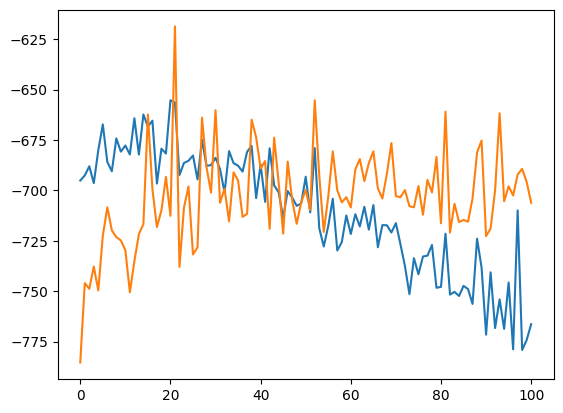

alpha 0.2 default_lr 0.0005


In [13]:
plt.plot(train_curve1)
plt.plot(valid_curve1)
plt.show()

# plt.plot(train_curve2)
# plt.plot(valid_curve2)
# plt.show()

# plt.plot(train_curve3)
# plt.plot(valid_curve3)
# plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [14]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [15]:
print(datetime.datetime.now())

2023-06-08 14:55:16.500266


# Iter2

In [16]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
predict diverge [  5.67599981  -6.91868889 -16.86727512 -29.87695935] [-0.22752667  1.08840431 -0.4930025  -8.23728617] [32.84908  10.318261 49.842476 22.503405] [16.42454    5.1591306 24.921238  11.251702 ] sim_timestep 143
 


In [17]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.83630  validloss 1.62255±0.00000  bestvalidloss 1.62255  last_update 0
train: iter 1  trainloss 0.58364  validloss 0.67975±0.00000  bestvalidloss 0.67975  last_update 0
train: iter 2  trainloss 0.54063  validloss 0.66895±0.00000  bestvalidloss 0.66895  last_update 0
train: iter 3  trainloss 0.52239  validloss 0.64724±0.00000  bestvalidloss 0.64724  last_update 0
train: iter 4  trainloss 0.51086  validloss 0.65482±0.00000  bestvalidloss 0.64724  last_update 1
train: iter 5  trainloss 0.49155  validloss 0.64114±0.00000  bestvalidloss 0.64114  last_update 0
train: iter 6  trainloss 0.49505  validloss 0.65907±0.00000  bestvalidloss 0.64114  last_update 1
train: iter 7  trainloss 0.48026  validloss 0.64368±0.00000  bestvalidloss 0.64114  last_update 2
train: iter 8  trainloss 0.47855  validloss 0.63816±0.00000  bestvalidloss 0.63816  last_update 0
train: iter 9  trainloss 0.47214  validloss 0.61994±0.00000  bestvalidloss 0.61994  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.42312  validloss 0.56026±0.00000  bestvalidloss 0.54703  last_update 17
train: iter 84  trainloss 0.41756  validloss 0.55629±0.00000  bestvalidloss 0.54703  last_update 18
train: iter 85  trainloss 0.41314  validloss 0.54874±0.00000  bestvalidloss 0.54703  last_update 19
train: iter 86  trainloss 0.40968  validloss 0.54938±0.00000  bestvalidloss 0.54703  last_update 20
train: iter 87  trainloss 0.41387  validloss 0.59394±0.00000  bestvalidloss 0.54703  last_update 21
train: iter 88  trainloss 0.40929  validloss 0.56637±0.00000  bestvalidloss 0.54703  last_update 22
train: iter 89  trainloss 0.41680  validloss 0.55519±0.00000  bestvalidloss 0.54703  last_update 23
train: iter 90  trainloss 0.41747  validloss 0.56934±0.00000  bestvalidloss 0.54703  last_update 24
train: iter 91  trainloss 0.40892  validloss 0.59066±0.00000  bestvalidloss 0.54703  last_update 25
train: iter 92  trainloss 0.40875  validloss 0.57974±0.00000  bestvalidloss 0.54703  last_update 26


train: iter 165  trainloss 0.39756  validloss 0.58017±0.00000  bestvalidloss 0.53352  last_update 55
train: iter 166  trainloss 0.38627  validloss 0.55487±0.00000  bestvalidloss 0.53352  last_update 56
train: iter 167  trainloss 0.39374  validloss 0.54780±0.00000  bestvalidloss 0.53352  last_update 57
train: iter 168  trainloss 0.40052  validloss 0.54615±0.00000  bestvalidloss 0.53352  last_update 58
train: iter 169  trainloss 0.38985  validloss 0.55800±0.00000  bestvalidloss 0.53352  last_update 59
train: iter 170  trainloss 0.38670  validloss 0.54591±0.00000  bestvalidloss 0.53352  last_update 60
train: iter 171  trainloss 0.38798  validloss 0.55281±0.00000  bestvalidloss 0.53352  last_update 61
train: iter 172  trainloss 0.38442  validloss 0.54394±0.00000  bestvalidloss 0.53352  last_update 62
train: iter 173  trainloss 0.38510  validloss 0.54415±0.00000  bestvalidloss 0.53352  last_update 63
train: iter 174  trainloss 0.38735  validloss 0.55163±0.00000  bestvalidloss 0.53352  last_

([0.8362977169454098,
  0.583635213971138,
  0.5406333977356553,
  0.5223863488994539,
  0.5108611950650811,
  0.49155173944309355,
  0.49504604330286384,
  0.48025848949328065,
  0.47855015508830545,
  0.47214414961636064,
  0.46805394627153873,
  0.472142165992409,
  0.4650145937688649,
  0.46636532209813597,
  0.46084851734340193,
  0.46143830083310605,
  0.46063795080408454,
  0.45202832370996476,
  0.4609454322606325,
  0.4574324021115899,
  0.4515331381931901,
  0.44785523423925044,
  0.45346814980730416,
  0.4643461911007762,
  0.44637038595974443,
  0.45814105179160836,
  0.4476789101958275,
  0.45570729207247496,
  0.4436338051222265,
  0.44387284507974983,
  0.4433643605560064,
  0.4461291154846549,
  0.44803853463381527,
  0.44875314375385644,
  0.435684996843338,
  0.4353695360943675,
  0.4444032285362482,
  0.43718086238950493,
  0.43672648826614024,
  0.4305778824724257,
  0.4305207124911249,
  0.42945445673540233,
  0.43201345959678294,
  0.43593412134796383,
  0.4365465

In [18]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -4.651344942870736
valid_loss:  -9.351600904631615
weight_alpha 1.0 h_min_tilde -11.823673 ell_tilde -5.5913961352229125 kappa_tilde 0.0004005683413858675
train_loss:  -4.054846417617798
valid_loss:  -4.441922451400758
weight_alpha 0.2 h_min_tilde -11.823673 ell_tilde -4.132261624374389 kappa_tilde 0.00036057612971475357


In [19]:
train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
iwvi.update_mulogvar_offlinedata()

# train_curve2, valid_curve2 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=2)
# iwvi.update_mulogvar_offlinedata()

# train_curve3, valid_curve3 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=3)
# iwvi.update_mulogvar_offlinedata()

weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -791.20129  validloss -889.67062±0.00000  bestvalidloss -889.67062  last_update 0
train: iter 1  trainloss -789.21490  validloss -890.52243±0.00000  bestvalidloss -890.52243  last_update 0
train: iter 2  trainloss -799.08852  validloss -908.63949±0.00000  bestvalidloss -908.63949  last_update 0
train: iter 3  trainloss -816.07519  validloss -820.85072±0.00000  bestvalidloss -908.63949  last_update 1
train: iter 4  trainloss -806.64662  validloss -866.80242±0.00000  bestvalidloss -908.63949  last_update 2
train: iter 5  trainloss -782.59890  validloss -873.54466±0.00000  bestvalidloss -908.63949  last_update 3
train: iter 6  trainloss -819.79536  validloss -879.90717±0.00000  bestvalidloss -908.63949  last_update 4
train: iter 7  trainloss -808.70357  validloss -884.71719±0.00000  bestvalidloss -908.63949  last_update 5
train: iter 8  trainloss -808.72640  validloss -888.28142±0.00000  bestvalidloss -908.63949  last_u

train: iter 76  trainloss -854.20122  validloss -837.23362±0.00000  bestvalidloss -922.64175  last_update 10
train: iter 77  trainloss -862.64184  validloss -875.78612±0.00000  bestvalidloss -922.64175  last_update 11
train: iter 78  trainloss -852.06847  validloss -856.28939±0.00000  bestvalidloss -922.64175  last_update 12
train: iter 79  trainloss -855.31692  validloss -815.93476±0.00000  bestvalidloss -922.64175  last_update 13
train: iter 80  trainloss -862.41379  validloss -862.11555±0.00000  bestvalidloss -922.64175  last_update 14
train: iter 81  trainloss -853.29821  validloss -849.08154±0.00000  bestvalidloss -922.64175  last_update 15
train: iter 82  trainloss -840.06328  validloss -852.00710±0.00000  bestvalidloss -922.64175  last_update 16
train: iter 83  trainloss -813.48781  validloss -847.72093±0.00000  bestvalidloss -922.64175  last_update 17
train: iter 84  trainloss -844.38417  validloss -846.06528±0.00000  bestvalidloss -922.64175  last_update 18
train: iter 85  tra

train: iter 151  trainloss -882.91793  validloss -814.81362±0.00000  bestvalidloss -933.08770  last_update 53
train: iter 152  trainloss -860.46905  validloss -814.91632±0.00000  bestvalidloss -933.08770  last_update 54
train: iter 153  trainloss -866.52813  validloss -757.76067±0.00000  bestvalidloss -933.08770  last_update 55
train: iter 154  trainloss -864.86115  validloss -797.17055±0.00000  bestvalidloss -933.08770  last_update 56
train: iter 155  trainloss -835.68154  validloss -799.92944±0.00000  bestvalidloss -933.08770  last_update 57
train: iter 156  trainloss -876.61560  validloss -785.05703±0.00000  bestvalidloss -933.08770  last_update 58
train: iter 157  trainloss -885.45725  validloss -813.27000±0.00000  bestvalidloss -933.08770  last_update 59
train: iter 158  trainloss -875.06294  validloss -844.46735±0.00000  bestvalidloss -933.08770  last_update 60
train: iter 159  trainloss -866.82716  validloss -799.36747±0.00000  bestvalidloss -933.08770  last_update 61
train: ite

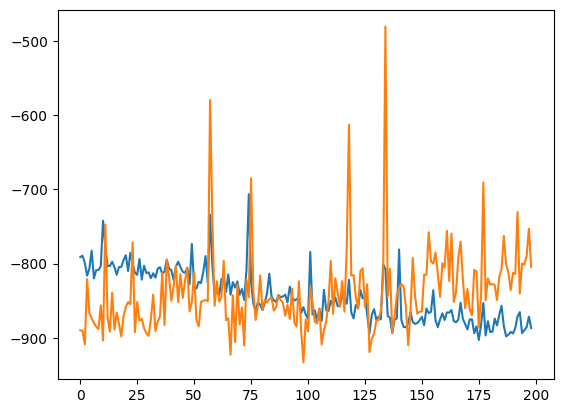

alpha 0.2 default_lr 0.0005


In [20]:
plt.plot(train_curve1)
plt.plot(valid_curve1)
plt.show()

# plt.plot(train_curve2)
# plt.plot(valid_curve2)
# plt.show()

# plt.plot(train_curve3)
# plt.plot(valid_curve3)
# plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [21]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)


In [22]:
print(datetime.datetime.now())

2023-06-08 15:13:12.776952


Text(0, 0.5, 'loss')

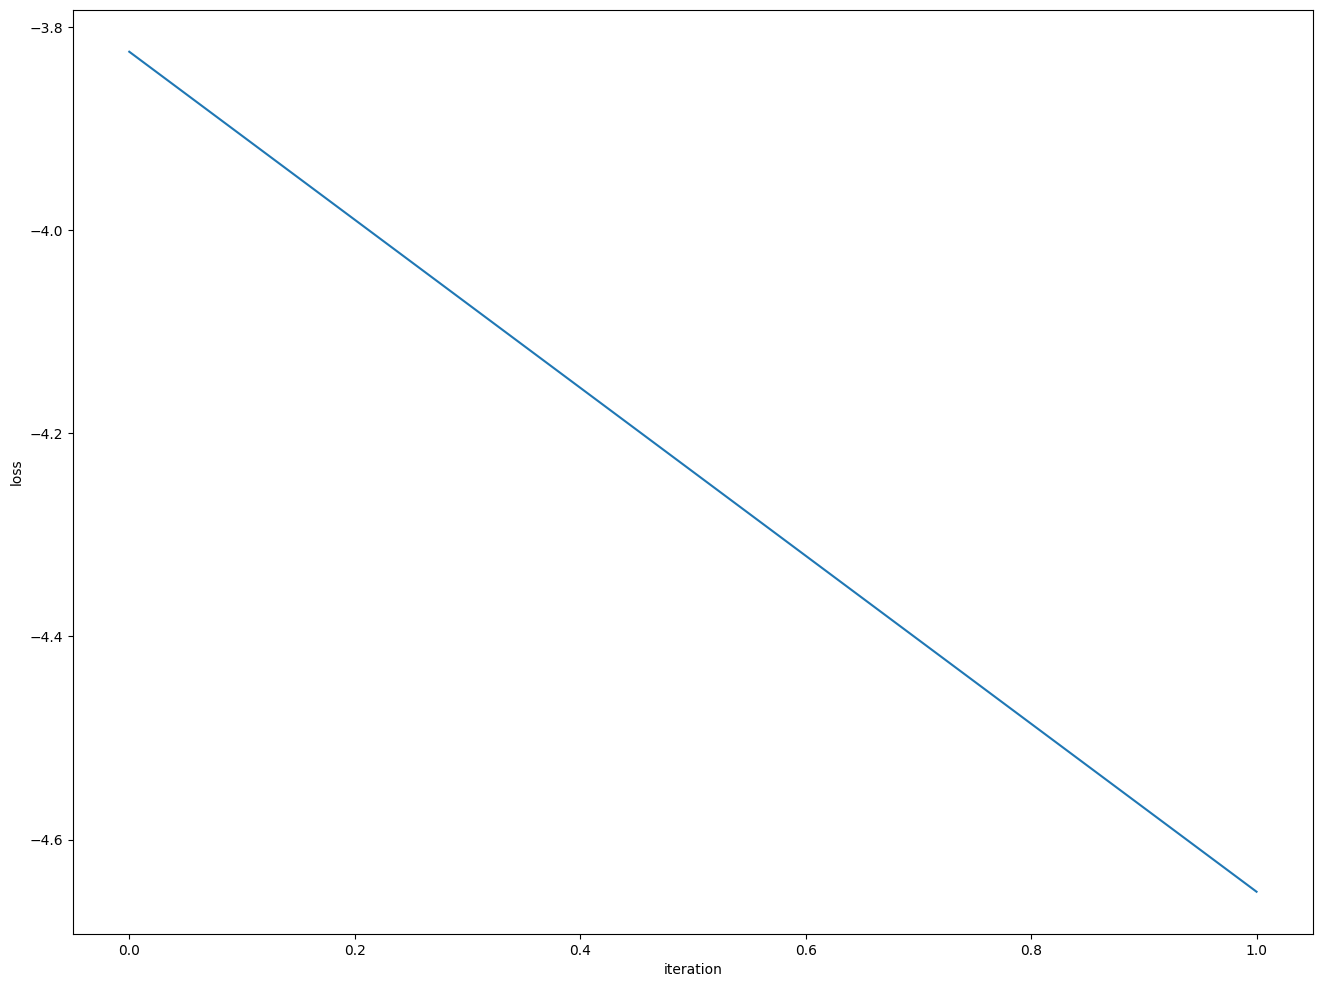

In [23]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")


Text(0, 0.5, 'loss')

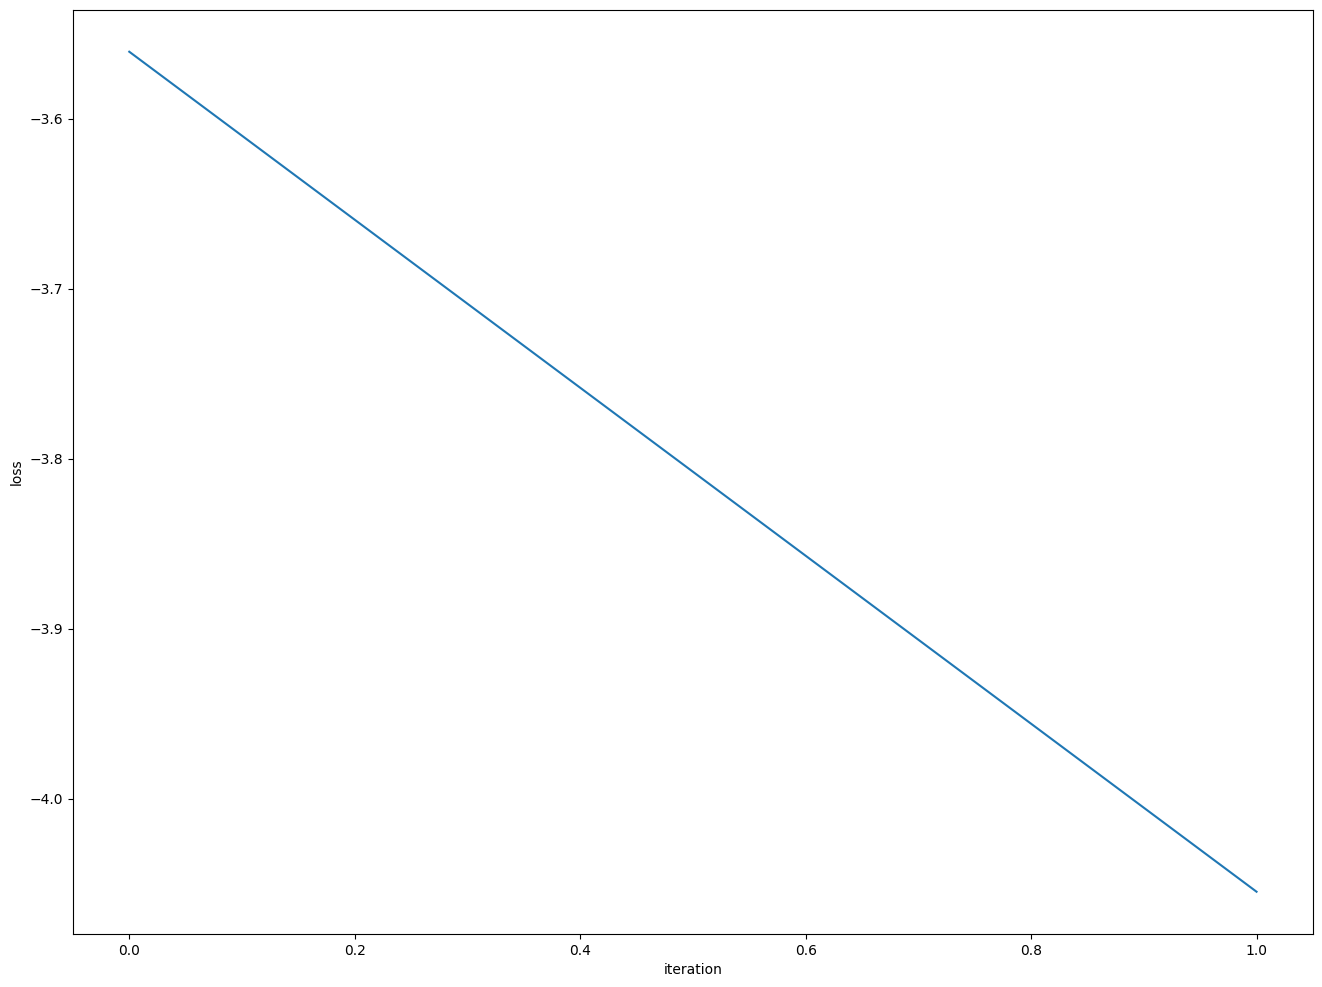

In [24]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")


# Iter 3

In [25]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7

 8

 9

 10

 11

 12

 13

 14

 15

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32

 33

 34

 35

 36

 37

 38

 39

 40

 41

 42
predict diverge [-11.79437603 -10.31921496  -0.53251593  -0.25740273] [-0.25319238 -0.1755882  -0.01097531  0.02819695] [32.84908  10.318261 49.842476 22.503405] [16.42454    5.1591306 24.921238  11.251702 ] sim_timestep 166

 43

 44

 45

 46

 47

 48

 49

 50

 51

 52

 53

 54

 55

 56

 57

 58

 59

 60

 61

 62

 63

 64

 65

 66

 67

 68

 69

 70

 71

 72

 73

 74

 75

 76

 77

 78

 79

 80

 81

 82

 83

 84

 85

 86

 87

 88

 89

 90

 91

 92

 93

 94

 95

 96

 97

 98

 99
 


In [26]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.92603  validloss 2.24291±0.00000  bestvalidloss 2.24291  last_update 0
train: iter 1  trainloss 0.65118  validloss 0.90556±0.00000  bestvalidloss 0.90556  last_update 0
train: iter 2  trainloss 0.59064  validloss 0.79613±0.00000  bestvalidloss 0.79613  last_update 0
train: iter 3  trainloss 0.56420  validloss 0.75798±0.00000  bestvalidloss 0.75798  last_update 0
train: iter 4  trainloss 0.53939  validloss 0.72435±0.00000  bestvalidloss 0.72435  last_update 0
train: iter 5  trainloss 0.54343  validloss 0.71095±0.00000  bestvalidloss 0.71095  last_update 0
train: iter 6  trainloss 0.52675  validloss 0.71984±0.00000  bestvalidloss 0.71095  last_update 1
train: iter 7  trainloss 0.51736  validloss 0.70058±0.00000  bestvalidloss 0.70058  last_update 0
train: iter 8  trainloss 0.51393  validloss 0.71319±0.00000  bestvalidloss 0.70058  last_update 1
train: iter 9  trainloss 0.50478  validloss 0.68725±0.00000  bestvalidloss 0.68725  last_update 0
train: iter 10  trai

train: iter 83  trainloss 0.42603  validloss 0.64593±0.00000  bestvalidloss 0.62304  last_update 5
train: iter 84  trainloss 0.42700  validloss 0.62831±0.00000  bestvalidloss 0.62304  last_update 6
train: iter 85  trainloss 0.41864  validloss 0.63710±0.00000  bestvalidloss 0.62304  last_update 7
train: iter 86  trainloss 0.43042  validloss 0.63225±0.00000  bestvalidloss 0.62304  last_update 8
train: iter 87  trainloss 0.42925  validloss 0.66341±0.00000  bestvalidloss 0.62304  last_update 9
train: iter 88  trainloss 0.42669  validloss 0.61648±0.00000  bestvalidloss 0.61648  last_update 0
train: iter 89  trainloss 0.42489  validloss 0.62535±0.00000  bestvalidloss 0.61648  last_update 1
train: iter 90  trainloss 0.42271  validloss 0.62873±0.00000  bestvalidloss 0.61648  last_update 2
train: iter 91  trainloss 0.42715  validloss 0.63278±0.00000  bestvalidloss 0.61648  last_update 3
train: iter 92  trainloss 0.41988  validloss 0.62402±0.00000  bestvalidloss 0.61648  last_update 4
train: ite

train: iter 166  trainloss 0.39942  validloss 0.65471±0.00000  bestvalidloss 0.60858  last_update 7
train: iter 167  trainloss 0.39957  validloss 0.61223±0.00000  bestvalidloss 0.60858  last_update 8
train: iter 168  trainloss 0.40311  validloss 0.61232±0.00000  bestvalidloss 0.60858  last_update 9
train: iter 169  trainloss 0.41029  validloss 0.67409±0.00000  bestvalidloss 0.60858  last_update 10
train: iter 170  trainloss 0.39916  validloss 0.62338±0.00000  bestvalidloss 0.60858  last_update 11
train: iter 171  trainloss 0.39374  validloss 0.60781±0.00000  bestvalidloss 0.60781  last_update 0
train: iter 172  trainloss 0.39907  validloss 0.61848±0.00000  bestvalidloss 0.60781  last_update 1
train: iter 173  trainloss 0.40131  validloss 0.61951±0.00000  bestvalidloss 0.60781  last_update 2
train: iter 174  trainloss 0.40554  validloss 0.61450±0.00000  bestvalidloss 0.60781  last_update 3
train: iter 175  trainloss 0.39968  validloss 0.60337±0.00000  bestvalidloss 0.60337  last_update 

train: iter 248  trainloss 0.38569  validloss 0.60778±0.00000  bestvalidloss 0.59502  last_update 43
train: iter 249  trainloss 0.38240  validloss 0.61033±0.00000  bestvalidloss 0.59502  last_update 44
train: iter 250  trainloss 0.39209  validloss 0.60428±0.00000  bestvalidloss 0.59502  last_update 45
train: iter 251  trainloss 0.38117  validloss 0.60682±0.00000  bestvalidloss 0.59502  last_update 46
train: iter 252  trainloss 0.38343  validloss 0.60531±0.00000  bestvalidloss 0.59502  last_update 47
train: iter 253  trainloss 0.37549  validloss 0.60366±0.00000  bestvalidloss 0.59502  last_update 48
train: iter 254  trainloss 0.37417  validloss 0.60943±0.00000  bestvalidloss 0.59502  last_update 49
train: iter 255  trainloss 0.37846  validloss 0.59922±0.00000  bestvalidloss 0.59502  last_update 50
train: iter 256  trainloss 0.38459  validloss 0.61977±0.00000  bestvalidloss 0.59502  last_update 51
train: iter 257  trainloss 0.37575  validloss 0.59248±0.00000  bestvalidloss 0.59248  last_

train: iter 330  trainloss 0.36654  validloss 0.59567±0.00000  bestvalidloss 0.58953  last_update 38
train: iter 331  trainloss 0.36632  validloss 0.59799±0.00000  bestvalidloss 0.58953  last_update 39
train: iter 332  trainloss 0.37289  validloss 0.60423±0.00000  bestvalidloss 0.58953  last_update 40
train: iter 333  trainloss 0.36159  validloss 0.59345±0.00000  bestvalidloss 0.58953  last_update 41
train: iter 334  trainloss 0.36681  validloss 0.59941±0.00000  bestvalidloss 0.58953  last_update 42
train: iter 335  trainloss 0.36713  validloss 0.60678±0.00000  bestvalidloss 0.58953  last_update 43
train: iter 336  trainloss 0.36348  validloss 0.60836±0.00000  bestvalidloss 0.58953  last_update 44
train: iter 337  trainloss 0.36491  validloss 0.62806±0.00000  bestvalidloss 0.58953  last_update 45
train: iter 338  trainloss 0.36811  validloss 0.61616±0.00000  bestvalidloss 0.58953  last_update 46
train: iter 339  trainloss 0.36326  validloss 0.62108±0.00000  bestvalidloss 0.58953  last_

([0.9260261829942464,
  0.6511799771338701,
  0.5906362939625979,
  0.5642004016786814,
  0.5393933426588774,
  0.5434276767075061,
  0.5267501538619399,
  0.5173605568706989,
  0.5139348862692714,
  0.5047777583822608,
  0.502681240439415,
  0.5007444512099027,
  0.495179414562881,
  0.49553498085588216,
  0.4860676731914282,
  0.48798456471413376,
  0.48778792936354876,
  0.49902847595512867,
  0.4809766564518213,
  0.4762022217735648,
  0.48609540723264216,
  0.4693359209224582,
  0.47846137881278994,
  0.47328100111335514,
  0.47331217769533396,
  0.46851129168644545,
  0.461458489485085,
  0.46607978325337174,
  0.4621243182569742,
  0.46209111865609886,
  0.46394625790417193,
  0.45830078721046447,
  0.46415230352431536,
  0.4600619884207845,
  0.4596860369667411,
  0.4628053901717067,
  0.4658312886953354,
  0.45335558596998454,
  0.4591149115934968,
  0.45702017275616524,
  0.45376878501847384,
  0.45214045885950327,
  0.4506714137271047,
  0.45092394659295676,
  0.447591394372

In [27]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -4.665806098121405
valid_loss:  -10.981562882423402
weight_alpha 1.0 h_min_tilde -11.888294 ell_tilde -5.928957454981804 kappa_tilde 0.0004096387534073378
train_loss:  -3.64731084575653
valid_loss:  -4.143121968841553
weight_alpha 0.2 h_min_tilde -11.888294 ell_tilde -3.7464730703735345 kappa_tilde 0.000350460616803312


In [28]:
train_curve1, valid_curve1 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, weight_alpha=alpha, flag=1)
iwvi.update_mulogvar_offlinedata()

# train_curve2, valid_curve2 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=100, weight_alpha=alpha, flag=2)
# iwvi.update_mulogvar_offlinedata()

# train_curve3, valid_curve3 = iwvi.train_weighted_vae(num_iter=num_iter_max, lr=vae_lr, early_stop_step=100, weight_alpha=alpha, flag=3)
# iwvi.update_mulogvar_offlinedata()

weight_alpha 0.2
train_weighted_vae: enc_dec
train: iter 0  trainloss -765.35591  validloss -830.13773±0.00000  bestvalidloss -830.13773  last_update 0
train: iter 1  trainloss -770.36358  validloss -872.58655±0.00000  bestvalidloss -872.58655  last_update 0
train: iter 2  trainloss -772.65535  validloss -860.67369±0.00000  bestvalidloss -872.58655  last_update 1
train: iter 3  trainloss -771.23212  validloss -851.30377±0.00000  bestvalidloss -872.58655  last_update 2
train: iter 4  trainloss -769.58918  validloss -860.92720±0.00000  bestvalidloss -872.58655  last_update 3
train: iter 5  trainloss -770.91271  validloss -879.67370±0.00000  bestvalidloss -879.67370  last_update 0
train: iter 6  trainloss -761.32198  validloss -869.68541±0.00000  bestvalidloss -879.67370  last_update 1
train: iter 7  trainloss -764.24418  validloss -858.70865±0.00000  bestvalidloss -879.67370  last_update 2
train: iter 8  trainloss -754.44612  validloss -832.78726±0.00000  bestvalidloss -879.67370  last_u

train: iter 75  trainloss -765.23993  validloss -795.82797±0.00000  bestvalidloss -879.67370  last_update 70
train: iter 76  trainloss -770.11112  validloss -827.81849±0.00000  bestvalidloss -879.67370  last_update 71
train: iter 77  trainloss -765.60707  validloss -810.21063±0.00000  bestvalidloss -879.67370  last_update 72
train: iter 78  trainloss -769.38576  validloss -837.83770±0.00000  bestvalidloss -879.67370  last_update 73
train: iter 79  trainloss -761.74799  validloss -801.51188±0.00000  bestvalidloss -879.67370  last_update 74
train: iter 80  trainloss -768.90897  validloss -825.66842±0.00000  bestvalidloss -879.67370  last_update 75
train: iter 81  trainloss -768.93694  validloss -818.34279±0.00000  bestvalidloss -879.67370  last_update 76
train: iter 82  trainloss -776.37396  validloss -823.75219±0.00000  bestvalidloss -879.67370  last_update 77
train: iter 83  trainloss -770.40432  validloss -791.44011±0.00000  bestvalidloss -879.67370  last_update 78
train: iter 84  tra

train: iter 150  trainloss -789.93445  validloss -797.66104±0.00000  bestvalidloss -884.31443  last_update 61
train: iter 151  trainloss -792.16986  validloss -786.55798±0.00000  bestvalidloss -884.31443  last_update 62
train: iter 152  trainloss -793.95105  validloss -765.78671±0.00000  bestvalidloss -884.31443  last_update 63
train: iter 153  trainloss -791.36712  validloss -806.56376±0.00000  bestvalidloss -884.31443  last_update 64
train: iter 154  trainloss -794.13197  validloss -790.70950±0.00000  bestvalidloss -884.31443  last_update 65
train: iter 155  trainloss -788.89856  validloss -798.75895±0.00000  bestvalidloss -884.31443  last_update 66
train: iter 156  trainloss -798.60034  validloss -796.68254±0.00000  bestvalidloss -884.31443  last_update 67
train: iter 157  trainloss -804.05138  validloss -799.22689±0.00000  bestvalidloss -884.31443  last_update 68
train: iter 158  trainloss -787.21543  validloss -801.54266±0.00000  bestvalidloss -884.31443  last_update 69
train: ite

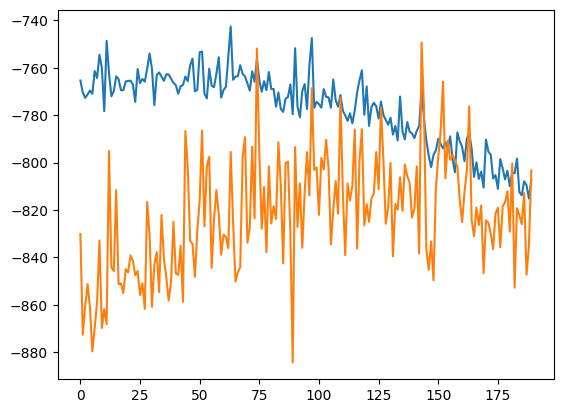

alpha 0.2 default_lr 0.0005


In [29]:
plt.plot(train_curve1)
plt.plot(valid_curve1)
plt.show()

# plt.plot(train_curve2)
# plt.plot(valid_curve2)
# plt.show()

# plt.plot(train_curve3)
# plt.plot(valid_curve3)
# plt.show()
print("alpha",alpha, "default_lr", default_lr)

In [30]:
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0a = copy.deepcopy(iwvi.simenv_rolloutdata)
# iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# simdata0b = copy.deepcopy(iwvi.simenv_rolloutdata)
# # iwvi.get_sim_rollout_bamdppolicy_data_fixlen()
# # simdata0c = copy.deepcopy(iwvi.simenv_rolloutdata)



In [31]:
print(datetime.datetime.now())

2023-06-08 15:36:17.375313


# 評価関数計算

In [32]:
iwvi.get_sim_rollout_bamdppolicy_data_randomstop()


 0

 1

 2

 3

 4

 5

 6

 7
predict diverge [  6.267491    10.47535702 -16.57831843 -15.32611063] [ 0.16179731  0.41731833 -0.35841707 -0.82582101] [32.84908  10.318261 49.842476 22.503405] [16.42454    5.1591306 24.921238  11.251702 ] sim_timestep 106

 8

 9

 10

 11

 12

 13

 14

 15
predict diverge [ 8.51280568 10.50228365  0.69875174 13.71049957] [0.17566079 0.59425046 0.30473162 0.74189663] [32.84908  10.318261 49.842476 22.503405] [16.42454    5.1591306 24.921238  11.251702 ] sim_timestep 137

 16

 17

 18

 19

 20

 21

 22

 23

 24

 25

 26

 27

 28

 29

 30

 31

 32
predict diverge [ 5.71598541 10.40047117 -7.30511554 -6.58298117] [ 0.18944882  0.24609154 -0.17894529  0.03461768] [32.84908  10.318261 49.842476 22.503405] [16.42454    5.1591306 24.921238  11.251702 ] sim_timestep 72

 33

 34

 35

 36

 37

 38

 39

 40

 41
predict diverge [ 3.99017769 10.41083734 -6.28660287 -8.81207637] [ 0.12804996  0.36304839 -0.21832632 -0.11370332] [32.84908  10.318261 4

In [33]:
iwvi.train_ratio(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early, policy=agent.select_action)


train: iter 0  trainloss 0.64779  validloss 1.50289±0.00000  bestvalidloss 1.50289  last_update 0
train: iter 1  trainloss 0.54702  validloss 0.83286±0.00000  bestvalidloss 0.83286  last_update 0
train: iter 2  trainloss 0.53198  validloss 0.80831±0.00000  bestvalidloss 0.80831  last_update 0
train: iter 3  trainloss 0.51539  validloss 0.80858±0.00000  bestvalidloss 0.80831  last_update 1
train: iter 4  trainloss 0.49704  validloss 0.79051±0.00000  bestvalidloss 0.79051  last_update 0
train: iter 5  trainloss 0.49405  validloss 0.78605±0.00000  bestvalidloss 0.78605  last_update 0
train: iter 6  trainloss 0.48161  validloss 0.86725±0.00000  bestvalidloss 0.78605  last_update 1
train: iter 7  trainloss 0.47778  validloss 0.79334±0.00000  bestvalidloss 0.78605  last_update 2
train: iter 8  trainloss 0.46798  validloss 0.77381±0.00000  bestvalidloss 0.77381  last_update 0
train: iter 9  trainloss 0.47513  validloss 0.77978±0.00000  bestvalidloss 0.77381  last_update 1
train: iter 10  trai

train: iter 84  trainloss 0.41841  validloss 0.78178±0.00000  bestvalidloss 0.73065  last_update 35
train: iter 85  trainloss 0.41317  validloss 0.73569±0.00000  bestvalidloss 0.73065  last_update 36
train: iter 86  trainloss 0.40931  validloss 0.76040±0.00000  bestvalidloss 0.73065  last_update 37
train: iter 87  trainloss 0.42078  validloss 0.76850±0.00000  bestvalidloss 0.73065  last_update 38
train: iter 88  trainloss 0.41069  validloss 0.77309±0.00000  bestvalidloss 0.73065  last_update 39
train: iter 89  trainloss 0.41343  validloss 0.75088±0.00000  bestvalidloss 0.73065  last_update 40
train: iter 90  trainloss 0.41745  validloss 0.74383±0.00000  bestvalidloss 0.73065  last_update 41
train: iter 91  trainloss 0.40777  validloss 0.74674±0.00000  bestvalidloss 0.73065  last_update 42
train: iter 92  trainloss 0.41376  validloss 0.76089±0.00000  bestvalidloss 0.73065  last_update 43
train: iter 93  trainloss 0.40812  validloss 0.74287±0.00000  bestvalidloss 0.73065  last_update 44


([0.647785859927535,
  0.5470193775370717,
  0.5319789073430001,
  0.5153919006697834,
  0.4970388475805521,
  0.49404594823718073,
  0.4816149706952274,
  0.4777833906933665,
  0.4679750334471464,
  0.4751323204487562,
  0.4672331867739558,
  0.46504503563046456,
  0.4598558367229998,
  0.45793385338038206,
  0.46299332566559315,
  0.46007353272289037,
  0.45369764901697635,
  0.45633169580250976,
  0.4537375412881374,
  0.45643755281344056,
  0.45692559154704215,
  0.4488070705905557,
  0.4440999790094793,
  0.4579925139434636,
  0.44985674452036617,
  0.4453031183220446,
  0.4456863544881344,
  0.4432145696133375,
  0.4493006979115307,
  0.4457022157497704,
  0.44144540205597876,
  0.44213499473407863,
  0.4389992423355579,
  0.4374569029547274,
  0.44287804467603564,
  0.45233684657141565,
  0.4415240854024887,
  0.43553887149319054,
  0.4424958544783294,
  0.437331316806376,
  0.43699514484032986,
  0.4385136589407921,
  0.4341166433878243,
  0.4358705226331949,
  0.43319893227890

In [34]:
loss_list.append(iwvi.eval_loss(weight_alpha=1.))
normalized_loss_list.append(iwvi.eval_loss(weight_alpha=alpha))


train_loss:  -4.092941527342797
valid_loss:  -11.273590957033635
weight_alpha 1.0 h_min_tilde -12.159555 ell_tilde -5.529071413280963 kappa_tilde 0.00038835364310678655
train_loss:  -3.907940552425385
valid_loss:  -4.259701485633849
weight_alpha 0.2 h_min_tilde -12.159555 ell_tilde -3.978292739067078 kappa_tilde 0.0003496148177379814


In [35]:
train_curve, valid_curve = iwvi.train_initial_belief(num_iter=100000, lr=1e-3, early_stop_step=default_early)


train: iter 0  trainloss 294.56265  validloss 321.23820±0.00000  bestvalidloss 321.23820  last_update 0
train: iter 1  trainloss 250.21612  validloss 271.46073±0.00000  bestvalidloss 271.46073  last_update 0
train: iter 2  trainloss 214.21593  validloss 230.28133±0.00000  bestvalidloss 230.28133  last_update 0
train: iter 3  trainloss 183.87790  validloss 197.82683±0.00000  bestvalidloss 197.82683  last_update 0
train: iter 4  trainloss 159.87399  validloss 171.14234±0.00000  bestvalidloss 171.14234  last_update 0
train: iter 5  trainloss 139.02191  validloss 148.90839±0.00000  bestvalidloss 148.90839  last_update 0
train: iter 6  trainloss 120.92777  validloss 129.08945±0.00000  bestvalidloss 129.08945  last_update 0
train: iter 7  trainloss 106.82311  validloss 113.94771±0.00000  bestvalidloss 113.94771  last_update 0
train: iter 8  trainloss 93.31499  validloss 98.75045±0.00000  bestvalidloss 98.75045  last_update 0
train: iter 9  trainloss 82.53434  validloss 87.77524±0.00000  best

train: iter 84  trainloss -0.34088  validloss -0.44542±0.00000  bestvalidloss -0.49604  last_update 6
train: iter 85  trainloss -0.30380  validloss -0.45298±0.00000  bestvalidloss -0.49604  last_update 7
train: iter 86  trainloss -0.36749  validloss -0.48024±0.00000  bestvalidloss -0.49604  last_update 8
train: iter 87  trainloss -0.30094  validloss -0.45857±0.00000  bestvalidloss -0.49604  last_update 9
train: iter 88  trainloss -0.30643  validloss -0.49485±0.00000  bestvalidloss -0.49604  last_update 10
train: iter 89  trainloss -0.27251  validloss -0.44173±0.00000  bestvalidloss -0.49604  last_update 11
train: iter 90  trainloss -0.32643  validloss -0.46134±0.00000  bestvalidloss -0.49604  last_update 12
train: iter 91  trainloss -0.28969  validloss -0.47857±0.00000  bestvalidloss -0.49604  last_update 13
train: iter 92  trainloss -0.32589  validloss -0.46780±0.00000  bestvalidloss -0.49604  last_update 14
train: iter 93  trainloss -0.28409  validloss -0.48536±0.00000  bestvalidloss

train: iter 178  trainloss -0.31297  validloss -0.40127±0.00000  bestvalidloss -0.54619  last_update 78
train: iter 179  trainloss -0.33048  validloss -0.44035±0.00000  bestvalidloss -0.54619  last_update 79
train: iter 180  trainloss -0.32453  validloss -0.40788±0.00000  bestvalidloss -0.54619  last_update 80
train: iter 181  trainloss -0.35483  validloss -0.46054±0.00000  bestvalidloss -0.54619  last_update 81
train: iter 182  trainloss -0.33235  validloss -0.51119±0.00000  bestvalidloss -0.54619  last_update 82
train: iter 183  trainloss -0.33828  validloss -0.44834±0.00000  bestvalidloss -0.54619  last_update 83
train: iter 184  trainloss -0.32736  validloss -0.43627±0.00000  bestvalidloss -0.54619  last_update 84
train: iter 185  trainloss -0.33678  validloss -0.44248±0.00000  bestvalidloss -0.54619  last_update 85
train: iter 186  trainloss -0.36187  validloss -0.45942±0.00000  bestvalidloss -0.54619  last_update 86
train: iter 187  trainloss -0.31183  validloss -0.47842±0.00000 

In [36]:
print(iwvi.initial_belief)


Parameter containing:
tensor([ 2.2853,  1.0930, -4.1212, -2.2180], requires_grad=True)


In [37]:
train_curve, valid_curve = iwvi.train_penalty(num_iter=num_iter_max, lr=default_lr, early_stop_step=default_early)

train: iter 0  trainloss 3.55038  validloss 23.05586±0.00000  bestvalidloss 23.05586  last_update 0
train: iter 1  trainloss 2.42630  validloss 25.37716±0.00000  bestvalidloss 23.05586  last_update 1
train: iter 2  trainloss 2.32848  validloss 25.39015±0.00000  bestvalidloss 23.05586  last_update 2
train: iter 3  trainloss 2.33765  validloss 22.22702±0.00000  bestvalidloss 22.22702  last_update 0
train: iter 4  trainloss 2.30432  validloss 23.80745±0.00000  bestvalidloss 22.22702  last_update 1
train: iter 5  trainloss 2.26748  validloss 24.58207±0.00000  bestvalidloss 22.22702  last_update 2
train: iter 6  trainloss 2.24235  validloss 23.48371±0.00000  bestvalidloss 22.22702  last_update 3
train: iter 7  trainloss 2.27199  validloss 20.08384±0.00000  bestvalidloss 20.08384  last_update 0
train: iter 8  trainloss 2.20327  validloss 24.24425±0.00000  bestvalidloss 20.08384  last_update 1
train: iter 9  trainloss 2.19843  validloss 23.74615±0.00000  bestvalidloss 20.08384  last_update 2


train: iter 82  trainloss 2.13570  validloss 21.16180±0.00000  bestvalidloss 18.99681  last_update 39
train: iter 83  trainloss 2.09180  validloss 24.87531±0.00000  bestvalidloss 18.99681  last_update 40
train: iter 84  trainloss 2.09555  validloss 22.78875±0.00000  bestvalidloss 18.99681  last_update 41
train: iter 85  trainloss 2.08634  validloss 21.34409±0.00000  bestvalidloss 18.99681  last_update 42
train: iter 86  trainloss 2.07403  validloss 25.95385±0.00000  bestvalidloss 18.99681  last_update 43
train: iter 87  trainloss 2.07843  validloss 24.34227±0.00000  bestvalidloss 18.99681  last_update 44
train: iter 88  trainloss 2.08342  validloss 20.48883±0.00000  bestvalidloss 18.99681  last_update 45
train: iter 89  trainloss 2.04356  validloss 23.02625±0.00000  bestvalidloss 18.99681  last_update 46
train: iter 90  trainloss 2.00033  validloss 22.00852±0.00000  bestvalidloss 18.99681  last_update 47
train: iter 91  trainloss 2.09186  validloss 23.81370±0.00000  bestvalidloss 18.99

In [38]:
iwvi.save(ckpt_key="policy_optimization_iter1")

iwvi save ckpt1, ckpt2 ckpt_iwvi_basepartcartpole_policy_optimization_iter1 ckpt_iwvi_cartpole_policy_optimization_iter1
base save ckpt ckpt_basevi_cartpole_policy_optimization_iter1
base load self.initial_belief.data.sum() tensor(-2.9609)
base load dec.state_dict()['net_phat.0.weight'].sum() tensor(-12.1404)


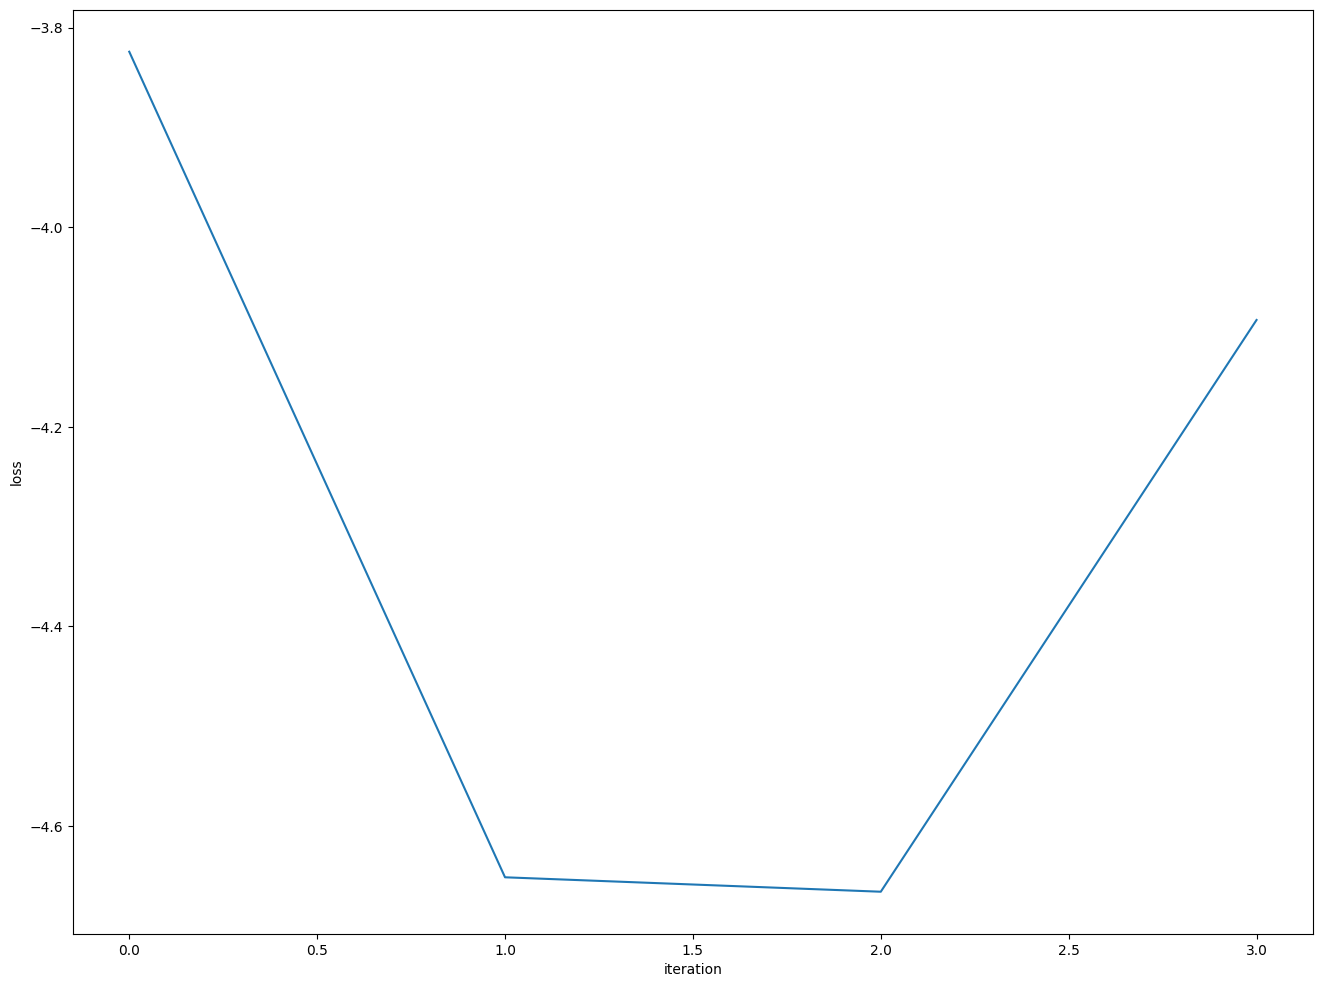

In [39]:
loss_array = np.array(loss_list)
plt.figure(figsize=(16,12))
plt.plot(loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve.png")
plt.savefig(figfilenamehead+"learning_curve.eps")
# plt.savefig(figfilenamehead+"policy_evaluartion_learning_curve.pdf")

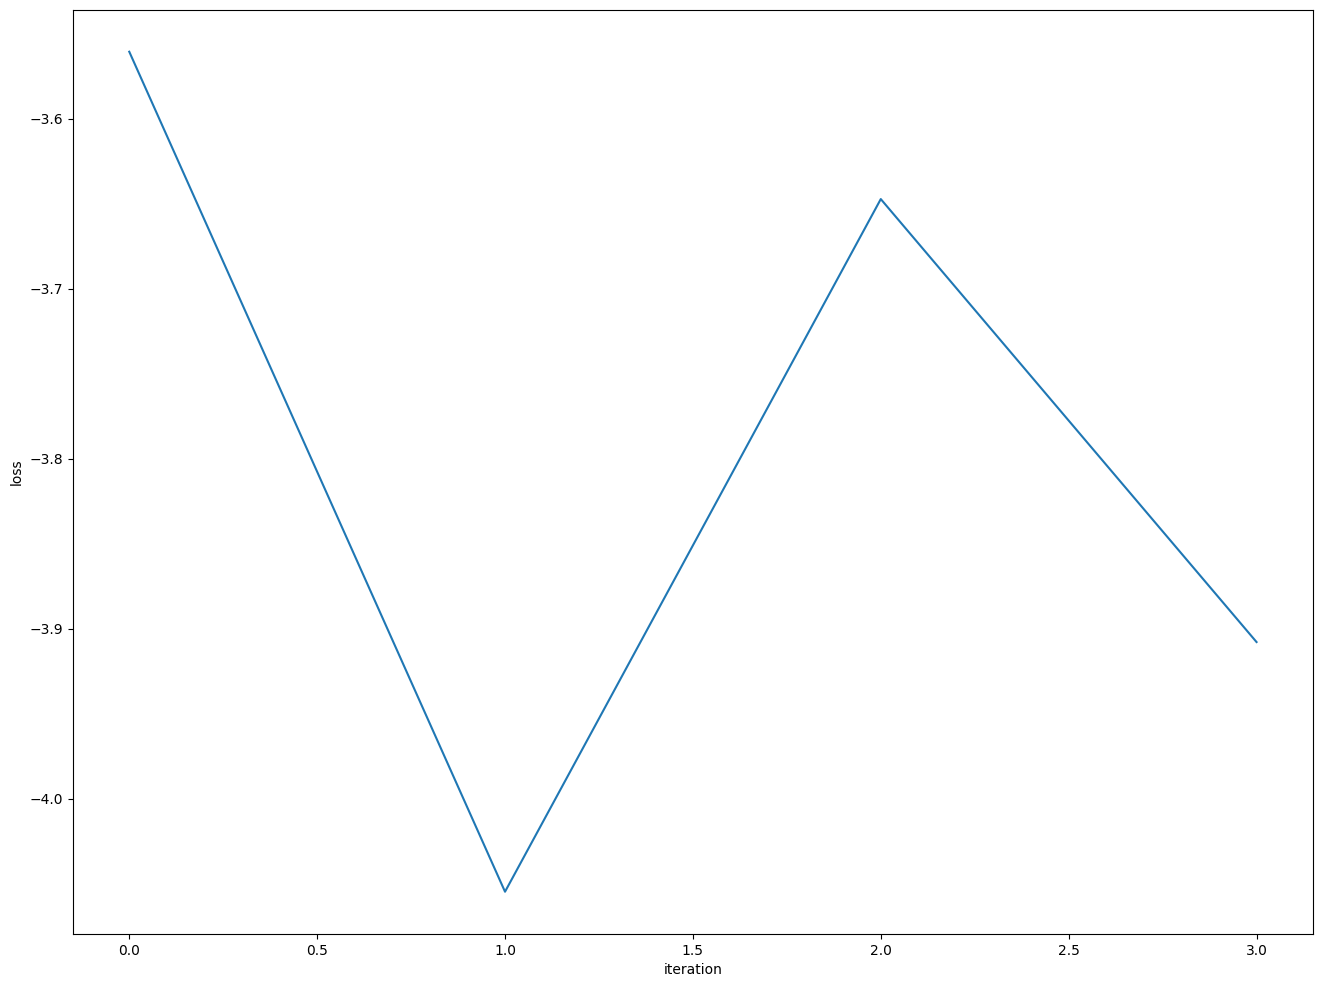

In [40]:
normalized_loss_array = np.array(normalized_loss_list)
plt.figure(figsize=(16,12))
plt.plot(normalized_loss_array[:,0])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".png")
plt.savefig(figfilenamehead+"learning_curve_normalized_"+env_str+".eps")